In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import numpy as np
import random
import math
from pydrake.common import temp_directory
from pydrake.geometry import StartMeshcat
from pydrake.systems.analysis import Simulator
from pydrake.visualization import ModelVisualizer
from pydrake.all import Simulator, StartMeshcat, LogVectorOutput

from manipulation import running_as_notebook
from manipulation.station import MakeHardwareStation, load_scenario
from IPython.display import HTML, display
from matplotlib import pyplot as plt
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    Box,
    ConnectPlanarSceneGraphVisualizer,
    DiagramBuilder,
    FixedOffsetFrame,
    JointIndex,
    Parser,
    PlanarJoint,
    RandomGenerator,
    RigidTransform,
    RotationMatrix,
    Simulator,
    StartMeshcat,
    UniformlyRandomRotationMatrix,
)

from manipulation import ConfigureParser, running_as_notebook
from manipulation.scenarios import AddShape, ycb
from manipulation.station import MakeHardwareStation, load_scenario
from pydrake.common import temp_directory

# sponana/src/sponana/utils.py
import sponana.utils
from sponana.controller import SpotController
from sponana.debug_logger import DebugLogger
from sponana.perception import add_camera_pose_extractor

In [9]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [40]:
# Clean up the Meshcat instance.
meshcat.Delete()
meshcat.DeleteAddedControls()

rng = np.random.default_rng(145)  # this is for python
generator = RandomGenerator(rng.integers(0, 1000))  # this is for c++

add_spot = True
simulation_time = -1  # run indefinitely until ESC is pressed
#simulation_time = 1
table_height = 0.2
debug = True

def distance_thres_point(poss_point_x, poss_point_y, x_points, y_points, r_threshold):
    #print("poss_point_x", poss_point_x, "poss_point_y", poss_point_y)
    for ind in range(len(x_points)):
        dist = math.hypot(abs(poss_point_x - x_points[ind]), abs(poss_point_y - y_points[ind]))
        print("dist", dist)
        if dist < r_threshold:
            return False
    return True


def generate_random_with_min_dist(x_upper_range, y_upper_range, num_elements):
    x_points = []
    y_points = []
    #max x collisions of the ycb objects: 0.158000 (cracker), 0.086700 (sugar box), 0.031850 radius (tomato soup can), 0.090000 (mustard bottle), 0.083200 (gelatin box), 0.095600 (SPAM)
    x_sample = np.arange(-x_upper_range, x_upper_range, 0.15)
    print("x_sample", x_sample)
    #max y collisions of the ycb objects: 0.207400 (cracker), 0.170300 (sugar box), 0.099900 length (tomato soup can), 0.160300 (mustard bottle), 0.067100 (gelatin box), 0.077500 (SPAM)
    y_sample = np.arange(-y_upper_range, y_upper_range, 0.20)
    print("y_sample", y_sample)
    while len(x_points) < num_elements:
        poss_point_x = np.random.choice(x_sample)
        poss_point_y = np.random.choice(y_sample)
        if distance_thres_point(poss_point_x, poss_point_y, x_points, y_points, 0.15):
            x_points.append(poss_point_x)
            y_points.append(poss_point_y)
            print("appended:", "x_points_append:", x_points, "y_points_append:", y_points)
    return x_points, y_points

def random_object_spawn(bodies_list, x_upper_bound, y_upper_bound, plant, plant_context, table):
    const = 0
    if table == "left":
         const = -2
    if table == "right":
         const = 2
        
    z = 0.2 + table_height
    num_elements = len(bodies_list)
    print("number of objects for table", num_elements)
    x_points, y_points = generate_random_with_min_dist(x_upper_bound, y_upper_bound, num_elements)
    print("x_points", x_points, "y_points", y_points)
    body_index = 0
    for body in bodies_list:
        random_z_theta = random.uniform(0, 2*np.pi)
        #print(random_z_theta)
        random_z_rotation = RotationMatrix.MakeZRotation(random_z_theta)
        #print("random z rotation:",random_z_rotation)
        tf = RigidTransform(
            #UniformlyRandomRotationMatrix(generator), #completely random rotation
            random_z_rotation,
            #[rng.uniform(-x_upper_bound, x_upper_bound), const + rng.uniform(-y_upper_bound, y_upper_bound), z],
            [x_points[body_index], const + y_points[body_index], z],
        )
        plant.SetFreeBodyPose(plant_context, plant.get_body(body), tf)
        z += 0.01
        body_index += 1


def clutter_gen():
    scenario_data = f"""
cameras:
    table_top_camera:
        name: camera0
        depth: True
        X_PB:
            base_frame: camera0::base
            translation: [0, 0, {-0.05 + table_height}]
            rotation: !Rpy {{ deg: [-90, 0, 0] }}
    """
    if add_spot:
        # camera welded to the chest of Spot
        scenario_data += """
    spot_camera:
        name: spot_camera
        depth: True
        X_PB:
            translation: [0, 0.05, 0]
            base_frame: spot_camera::base
            rotation: !Rpy { deg: [-90, 0, 0] }
    """

    scenario_data += f"""       
directives:
- add_model:
    name: camera0
    file: package://manipulation/camera_box.sdf
- add_weld:
    parent: world
    child: camera0::base
    X_PC:
        translation: [0, 1.75, 1.0]
        rotation: !Rpy {{ deg: [-75, 0, 0] }}
    
- add_model:
    name: table_top
    file: package://sponana/table_top.sdf

- add_weld:
    parent: world
    child: table_top::table_top_center
    X_PC:
        translation: [0, 0, {table_height}]

- add_model:
    name: table_top2
    file: package://sponana/table_top.sdf

- add_weld:
    parent: world
    child: table_top2::table_top_center
    X_PC:
        translation: [0, 2.0, {table_height}]

- add_model:
    name: table_top3
    file: package://sponana/table_top.sdf

- add_weld:
    parent: world
    child: table_top3::table_top_center
    X_PC:
        translation: [0, -2.0, {table_height}]

# Walls
- add_model:
    name: table_top4
    file: package://sponana/table_top4.sdf
- add_weld:
    parent: world
    child: table_top4::table_top4_center

- add_model:
    name: table_top5
    file: package://sponana/table_top5.sdf
- add_weld:
    parent: world
    child: table_top5::table_top5_center

- add_model:
    name: table_top6
    file: package://sponana/table_top6.sdf
- add_weld:
    parent: world
    child: table_top6::table_top6_center

- add_model:
    name: table_top7
    file: package://sponana/table_top7.sdf
- add_weld:
    parent: world
    child: table_top7::table_top7_center

- add_model:
    name: floor
    file: package://sponana/platform.sdf
- add_weld:
    parent: world
    child: floor::platform_center

- add_model:
    name: back_wall
    file: package://sponana/table_top9.sdf
- add_weld:
    parent: world
    child: back_wall::table_top9_center
    """

    for i in range(22 if running_as_notebook else 2):
        object_num = rng.integers(0, len(ycb))
        scenario_data += f"""
- add_model:
    name: thing{i}
    file: package://manipulation/hydro/{ycb[object_num]} 
"""
    scenario_data += f"""
- add_model:
    name: banana
    file: package://sponana/banana/banana.sdf
    default_free_body_pose:
        banana: 
            translation: [0, 0, 1]
            rotation: !Rpy {{ deg: [0, 0, 0] }}    
"""

    if add_spot:
        scenario_data += """
- add_model:
    name: spot
    file: package://manipulation/spot/spot_with_arm_and_floating_base_actuators.urdf
    default_joint_positions:
        # fold the arm
        arm_sh1: [-3.1]
        arm_el0: [3.1]
        # initial position
        base_x: [1.0]
        base_rz: [3.14]

- add_model:
    name: spot_camera
    file: package://manipulation/camera_box.sdf

- add_weld:
    parent: spot::body
    child: spot_camera::base
    X_PC:
        translation: [0.4, 0, 0]
        # pointed slightly downward (by 30 degrees)
        rotation: !Rpy { deg: [-30, 0, -90] }

model_drivers:
    spot: !InverseDynamicsDriver {}
"""

    builder = DiagramBuilder()
    scenario = load_scenario(data=scenario_data)
    station = builder.AddSystem(
        MakeHardwareStation(
            scenario, meshcat, parser_preload_callback=sponana.utils.configure_parser
        )
    )

    if add_spot:
        spot_plant = station.GetSubsystemByName(
            "spot.controller"
        ).get_multibody_plant_for_control()
        spot_controller = builder.AddSystem(SpotController(spot_plant, meshcat=meshcat))
        builder.Connect(
            spot_controller.get_output_port(),
            station.GetInputPort("spot.desired_state"),
        )

        # Get camera poses
        spot_camera_config = scenario.cameras["spot_camera"]
        camera_pose_extractor = add_camera_pose_extractor(
            spot_camera_config, station, builder
        )

        if debug:
            # Connect debugger
            spot_camera = station.GetSubsystemByName("rgbd_sensor_camera0")
            debugger = builder.AddNamedSystem(
                "debug_logger", DebugLogger(spot_camera, meshcat)
            )
            builder.Connect(
                station.GetOutputPort("spot_camera.rgb_image"),
                debugger.get_color_image_input_port(),
            )
            builder.Connect(
                station.GetOutputPort("spot_camera.depth_image"),
                debugger.get_depth_image_input_port(),
            )
            builder.Connect(
                camera_pose_extractor.get_output_port(),
                debugger.get_camera_pose_input_port(),
            )

    diagram = builder.Build()

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    plant = station.GetSubsystemByName("plant")
    plant_context = plant.GetMyContextFromRoot(context)

    #print("plant Floating Base", set(list(plant.GetFloatingBaseBodies())[0:3]))
    random_z_theta = random.uniform(0, 2*np.pi)
    print(random_z_theta)
    random_z_rotation = RotationMatrix.MakeZRotation(random_z_theta)
    print("random z rotation:",random_z_rotation)
    #print(type(plant.GetFloatingBaseBodies()))
    floating_base_bodies_list = list(plant.GetFloatingBaseBodies())
    len_bodies = len(floating_base_bodies_list)

    center_table_bodies = set(floating_base_bodies_list[0 : len_bodies // 3])
    x_upper_bound = 0.20
    y_upper_bound = 0.30
    random_object_spawn(center_table_bodies, x_upper_bound, y_upper_bound, plant, plant_context, "")

    right_table_bodies = set(
        floating_base_bodies_list[len_bodies // 3 : len_bodies // 3 * 2]
    )
    random_object_spawn(right_table_bodies, x_upper_bound, y_upper_bound, plant, plant_context, "right")

    left_table_bodies = set(floating_base_bodies_list[len_bodies // 3 * 2 :])
    random_object_spawn(left_table_bodies, x_upper_bound, y_upper_bound, plant, plant_context, "left")

    sponana.utils.run_simulation(simulator, meshcat, finish_time=simulation_time)
    return simulator, diagram


simulator, diagram = clutter_gen()

Press Space to log system info
1.0459592795946986
random z rotation: RotationMatrix([
  [0.5010719910608902, -0.8654056041962492, 0.0],
  [0.8654056041962492, 0.5010719910608902, 0.0],
  [0.0, 0.0, 1.0],
])
number of objects for table 7
x_sample [-0.2  -0.05  0.1 ]
y_sample [-0.3 -0.1  0.1]
appended: x_points_append: [-0.2] y_points_append: [0.10000000000000003]
dist 0.15
appended: x_points_append: [-0.2, -0.05000000000000002] y_points_append: [0.10000000000000003, 0.10000000000000003]
dist 0.15
dist 0.0
dist 0.15
dist 0.0
dist 0.2
dist 0.25
appended: x_points_append: [-0.2, -0.05000000000000002, -0.2] y_points_append: [0.10000000000000003, 0.10000000000000003, -0.09999999999999998]
dist 0.2
dist 0.25
dist 0.0
dist 0.0
dist 0.4
dist 0.42720018726587655
dist 0.2
appended: x_points_append: [-0.2, -0.05000000000000002, -0.2, -0.2] y_points_append: [0.10000000000000003, 0.10000000000000003, -0.09999999999999998, -0.3]
dist 0.4
dist 0.42720018726587655
dist 0.2
dist 0.0
dist 0.25
dist 0.2
d

==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html



KeyboardInterrupt: 

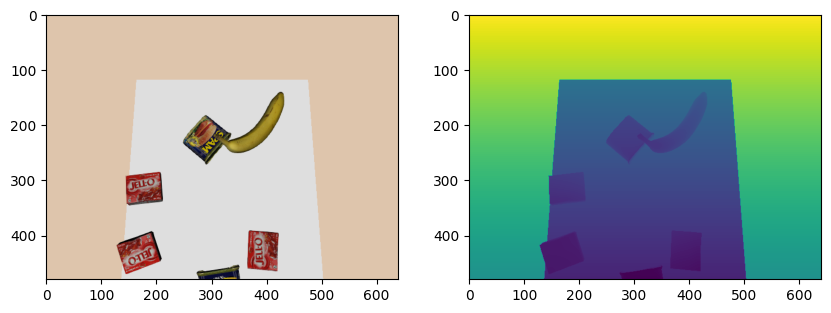

In [ ]:
# Check the camera on table top
context = simulator.get_mutable_context()
station = diagram.GetSubsystemByName("station")
context = station.GetMyContextFromRoot(context)
color_image = station.GetOutputPort("camera0.rgb_image").Eval(context)
depth_image = station.GetOutputPort("camera0.depth_image").Eval(context)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(color_image.data)
plt.subplot(1, 2, 2)
plt.imshow(depth_image.data)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3d6be65c-ca3c-46d4-a8f3-21f3622a2ace' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

In [ ]:
# Check the camera on Spot
context = simulator.get_mutable_context()
station = diagram.GetSubsystemByName("station")
context = station.GetMyContextFromRoot(context)
color_image = station.GetOutputPort("spot_camera.rgb_image").Eval(context)
depth_image = station.GetOutputPort("spot_camera.depth_image").Eval(context)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(color_image.data)
plt.subplot(1, 2, 2)
plt.imshow(depth_image.data)

RuntimeError: System station does not have an output port named camera1.rgb_image (valid port names: spot.state_estimated, camera0.rgb_image, camera0.depth_image, camera0.label_image, spot_camera.rgb_image, spot_camera.depth_image, spot_camera.label_image, query_object, contact_results, plant_continuous_state, body_poses)

In [ ]:
# camera intrinsics
camera1 = station.GetSubsystemByName("rgbd_sensor_spot_camera")
camera_info = camera1.depth_camera_info()
print("intrinsics", camera_info.intrinsic_matrix())
print("focal length", camera_info.focal_x(), camera_info.focal_y())
print("field of view", camera_info.fov_x(), camera_info.fov_y())

In [ ]:
# camera pose (X_PC)
context = simulator.get_mutable_context()
context = camera1.GetMyContextFromRoot(context)
camera1.GetOutputPort("body_pose_in_world").Eval(context)

In [ ]:
# Read out the table position from the hardware station

plant = station.GetSubsystemByName("plant")
pcontext = plant.GetMyContextFromRoot(context)
idx = plant.GetBodyByName("table_top_link", plant.GetModelInstanceByName("table_top")).index() # Get this
# get output port with body_poses
# then index into it by index -- see get_body_poses_output_port() docs!!
plant.get_body_poses_output_port().Eval(pcontext)[idx]

In [ ]:
sponana.utils.visualize_diagram(diagram, max_depth=1)